In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
import math
import pandas as pd

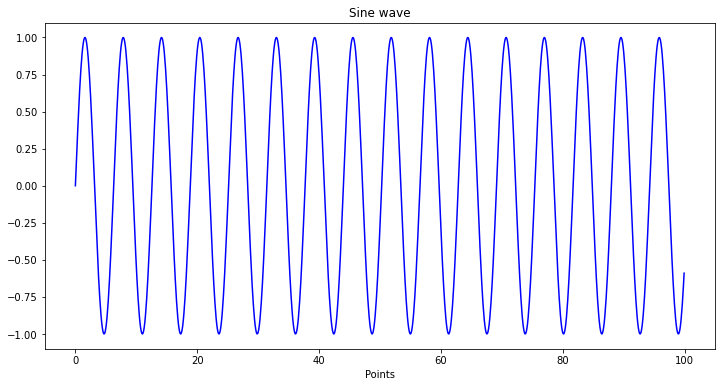

In [2]:
points = np.arange(0, 100, 0.1);
amplitude   = np.sin(points)
plt.figure(figsize=(12,6))
plt.plot(points, amplitude,color='blue')
plt.title('Sine wave')
plt.xlabel('Points')
plt.show()

In [3]:
# split into train and test sets
train_size = int(len(amplitude) * 0.67)
test_size = len(amplitude) - train_size
train, test = amplitude[0:train_size], amplitude[train_size:]
print(len(train), len(test))

670 330


In [4]:
def create_target(data,lookback):
    return data[:-lookback],data[lookback:]
trainX,trainY = create_target(train,1)
testX,testY = create_target(test,1)
print(len(trainX),len(trainY))

669 669


In [5]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(-1,1)
testX  = testX.reshape(-1,1)
print(trainX.shape)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(669, 1)
(669, 1, 1)


In [11]:
lookback = 1
model = Sequential()
model.add(LSTM(4, input_shape=(1, lookback),activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
67/67 - 1s - loss: 0.4593 - 801ms/epoch - 12ms/step
Epoch 2/100
67/67 - 0s - loss: 0.4221 - 49ms/epoch - 731us/step
Epoch 3/100
67/67 - 0s - loss: 0.3661 - 49ms/epoch - 731us/step
Epoch 4/100
67/67 - 0s - loss: 0.2951 - 54ms/epoch - 806us/step
Epoch 5/100
67/67 - 0s - loss: 0.2272 - 48ms/epoch - 716us/step
Epoch 6/100
67/67 - 0s - loss: 0.1750 - 48ms/epoch - 716us/step
Epoch 7/100
67/67 - 0s - loss: 0.1382 - 49ms/epoch - 731us/step
Epoch 8/100
67/67 - 0s - loss: 0.1115 - 49ms/epoch - 731us/step
Epoch 9/100
67/67 - 0s - loss: 0.0916 - 47ms/epoch - 701us/step
Epoch 10/100
67/67 - 0s - loss: 0.0767 - 48ms/epoch - 716us/step
Epoch 11/100
67/67 - 0s - loss: 0.0649 - 49ms/epoch - 731us/step
Epoch 12/100
67/67 - 0s - loss: 0.0560 - 49ms/epoch - 731us/step
Epoch 13/100
67/67 - 0s - loss: 0.0485 - 48ms/epoch - 716us/step
Epoch 14/100
67/67 - 0s - loss: 0.0424 - 48ms/epoch - 718us/step
Epoch 15/100
67/67 - 0s - loss: 0.0373 - 48ms/epoch - 716us/step
Epoch 16/100
67/67 - 0s - loss: 0.

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_preds = model.predict(trainX)
test_preds = model.predict(testX)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, train_preds[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, test_preds[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


In [9]:
preds = np.empty_like(amplitude)
preds[1:train_size] = train_preds[:,0]
preds[train_size+1:] = test_preds[:,0]
df = pd.DataFrame([amplitude,preds,preds]).T
df[1][0] = np.nan
df[1][train_size:] = np.nan
df[2][:train_size+1] =np.nan

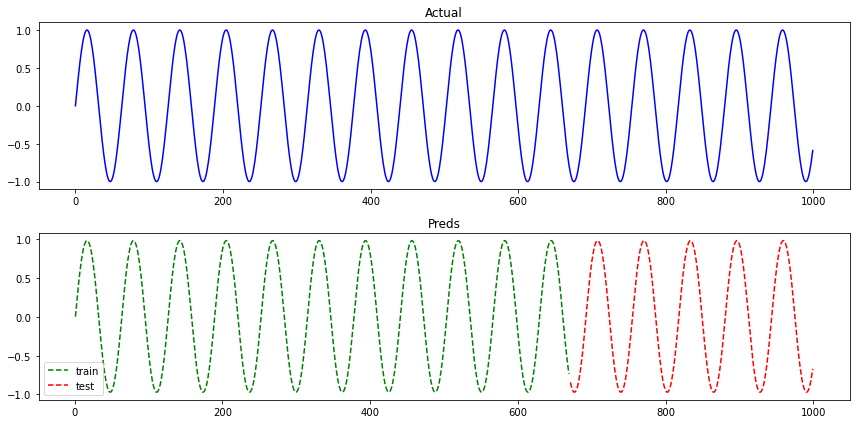

In [10]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
df[0].plot(ax=ax[0],label='actual',color='b')
df[1].plot(ax=ax[1],label='train',color='g',linestyle='--')
df[2].plot(ax=ax[1],label='test',color='r',linestyle='--')
ax[0].set_title('Actual')
ax[1].set_title('Preds')
fig.tight_layout()
plt.legend()
plt.show()

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchinfo

In [32]:
class torch_LSTM(nn.Module):
    def __init__(self):
        super(torch_LSTM,self).__init__()
        self.dense = 1
        self.input_size = 1
        self.hidden_size = 4
        
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,batch_first=True)
        self.fc_1 = nn.Linear(in_features=self.hidden_size,out_features=self.dense)
        self.relu = nn.Tanh()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(1, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(1, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        return out        
        


In [35]:
def train(trainX,testX,trainY,testY,net,epochs):
    net.train()
    optimiser = torch.optim.Adam(net.parameters(),lr=0.01)
    criterion = torch.nn.MSELoss()
    for epoch in range(epochs):
        outputs = net.forward(trainX)
        optimiser.zero_grad()
        loss = criterion(outputs,trainY)
        loss.backward()
        test_loss = evaluate(net,testX,testY)
        net.train()
        optimiser.step()
        print('Epoch:',epoch,'/',epochs,': Loss=',loss,'---- Test Loss=',test_loss)
    return net,loss,test_loss

def evaluate(net,testX,testY):
    net.eval()
    with torch.no_grad():
        outputs = net(testX)
    return mean_squared_error(testY,outputs)

In [36]:
model_torch = torch_LSTM()
trainX_tensor = Variable(torch.Tensor(trainX))
testX_tensor = Variable(torch.Tensor(testX))
trainY_tensor = Variable(torch.Tensor(trainY.reshape(-1,1))) 
testY_tensor = Variable(torch.Tensor(testY.reshape(-1,1)))
net,loss,test_loss = train(trainX_tensor,testX_tensor,trainY_tensor,testY_tensor,model_torch,100)

Epoch: 0 / 100 : Loss= tensor(0.4884, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.49318448
Epoch: 1 / 100 : Loss= tensor(0.4791, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.4859439
Epoch: 2 / 100 : Loss= tensor(0.4703, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.4791526
Epoch: 3 / 100 : Loss= tensor(0.4619, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.47261563
Epoch: 4 / 100 : Loss= tensor(0.4539, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.4662814
Epoch: 5 / 100 : Loss= tensor(0.4462, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.46013206
Epoch: 6 / 100 : Loss= tensor(0.4388, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.45411342
Epoch: 7 / 100 : Loss= tensor(0.4316, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.4481328
Epoch: 8 / 100 : Loss= tensor(0.4245, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.44206622
Epoch: 9 / 100 : Loss= tensor(0.4174, grad_fn=<MseLossBackward0>) ---- Test Loss= 0.4357746
Epoch: 10 / 100 : Loss= tensor(0.4102, grad_fn=<MseLossBackward0>) ---- Tes

In [37]:
torchinfo.summary(model_torch,(1, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
torch_LSTM                               --                        --
├─LSTM: 1-1                              [1, 1, 4]                 112
├─Tanh: 1-2                              [1, 4]                    --
├─Linear: 1-3                            [1, 1]                    5
Total params: 117
Trainable params: 117
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [38]:
train_preds = net(trainX_tensor).detach().numpy()
test_preds = net(testX_tensor).detach().numpy()
preds = np.empty_like(amplitude)
preds[1:train_size] = train_preds[:,0]
preds[train_size+1:] = test_preds[:,0]
df = pd.DataFrame([amplitude,preds,preds]).T
df[1][0] = np.nan
df[1][train_size:] = np.nan
df[2][:train_size+1] =np.nan

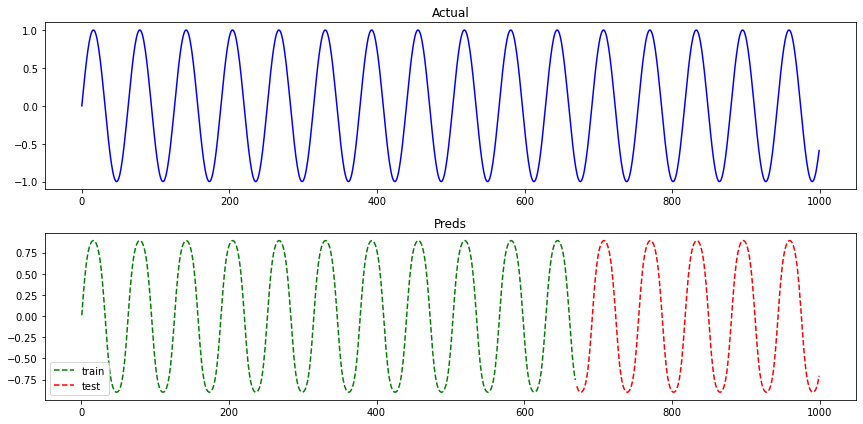

In [39]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
df[0].plot(ax=ax[0],label='actual',color='b')
df[1].plot(ax=ax[1],label='train',color='g',linestyle='--')
df[2].plot(ax=ax[1],label='test',color='r',linestyle='--')
ax[0].set_title('Actual')
ax[1].set_title('Preds')
fig.tight_layout()
plt.legend()
plt.show()